## Model Prototype 1
### Linear Regression

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import statsmodels.api as sm

# load data
df = pd.read_csv("cont_drone_simulation_data.csv")

# features and target
X = df[["payloads", "distances"]]   # choose the features you want
y = df["energy_used"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model
model = LinearRegression()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# evaluate
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))


MAE: 157129.63780191014
R^2: 0.8786773927918898


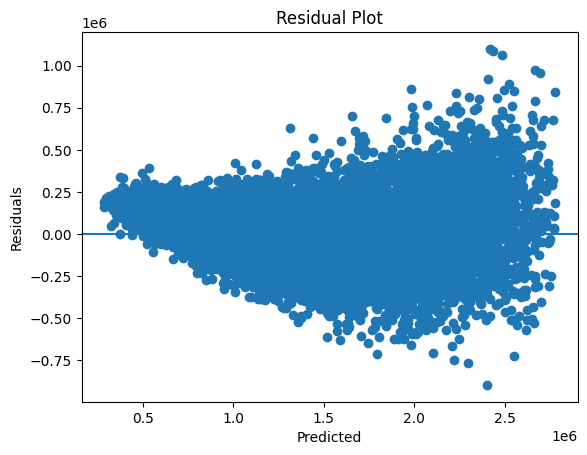

In [21]:
import matplotlib.pyplot as plt

pred = model.predict(X)
residuals = y - pred

plt.scatter(pred, residuals)
plt.axhline(0)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


## Model Prototype 2
### Polynomial Regression

0.8983273030125974


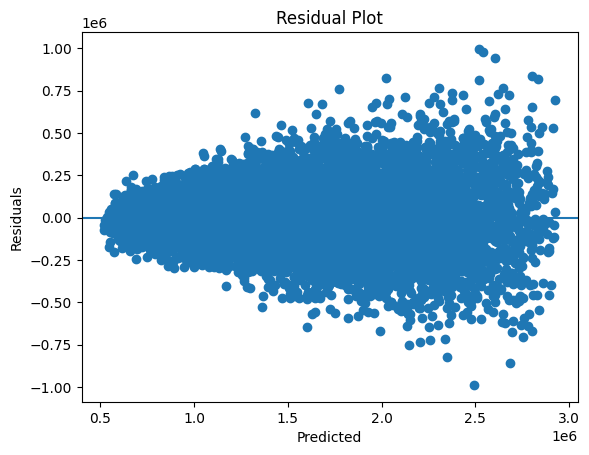

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

pred = model.predict(X_poly)
print(r2_score(y, pred))

pred = model.predict(X_poly)
residuals = y - pred

plt.scatter(pred, residuals)
plt.axhline(0)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

## Model Prototype 3
### Neural Network

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import torch


class EnergyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)
        
model = EnergyNN()



# load CSV
df = pd.read_csv("cont_drone_simulation_data.csv")

# features
X = df[['payloads', 'distances']].values.astype('float32')

# target
y = df['energy_used'].values.astype('float32')

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train).view(-1, 1)
y_test = torch.tensor(y_test).view(-1, 1)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 100
batch_size = 64

for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))

    for i in range(0, X_train.size(0), batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i + batch_size]
        batch_x = X_train[indices]
        batch_y = y_train[indices]

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()
    y_true = y_test.numpy()

print("MAE:", mean_absolute_error(y_true, preds))
print("R² :", r2_score(y_true, preds))


Epoch [10/100], Loss: 2834210750464.0000
Epoch [20/100], Loss: 2390225321984.0000
Epoch [30/100], Loss: 2561526202368.0000
Epoch [40/100], Loss: 2299121893376.0000
Epoch [50/100], Loss: 1512569831424.0000
Epoch [60/100], Loss: 972225118208.0000
Epoch [70/100], Loss: 634144882688.0000
Epoch [80/100], Loss: 389159157760.0000
Epoch [90/100], Loss: 229206540288.0000
Epoch [100/100], Loss: 126443978752.0000
MAE: 304229.59375
R² : 0.6132091283798218


## Model Prototype 4
### Scaled Neural Network

In [25]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# X, y = your features and energy_used
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale inputs and target
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

# Simple NN
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

# Predict and inverse scale
preds_scaled = model(X_test_t).detach().numpy()
preds = y_scaler.inverse_transform(preds_scaled)


Epoch [10/100], Loss: 0.8711
Epoch [20/100], Loss: 0.5424
Epoch [30/100], Loss: 0.3271
Epoch [40/100], Loss: 0.2062
Epoch [50/100], Loss: 0.1497
Epoch [60/100], Loss: 0.1299
Epoch [70/100], Loss: 0.1203
Epoch [80/100], Loss: 0.1127
Epoch [90/100], Loss: 0.1099
Epoch [100/100], Loss: 0.1077


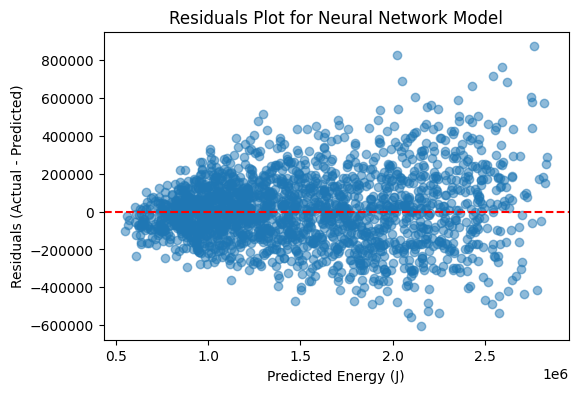

R²: 0.9002684354782104


In [26]:
import matplotlib.pyplot as plt

# Residuals
residuals = y_test.flatten() - preds.flatten()

plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Energy (J)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot for Neural Network Model')
plt.show()


from sklearn.metrics import r2_score

r2 = r2_score(y_test.flatten(), preds.flatten())
print("R²:", r2)